In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

<IPython.core.display.Javascript object>

Import the backtest results from Andreas Clenow's [website](https://www.followingthetrend.com/trading-evolved/):

In [3]:
%%bash
cd /tmp
rm -rf trading_evolved
rm -f trading_evolved.zip

wget -q -O trading_evolved.zip trading_evolved.zip https://dl.dropbox.com/s/tj85sufbsi820ya/Trading%20Evolved.zip?dl=1
unzip -q -d trading_evolved trading_evolved.zip
ls -lah trading_evolved/Backtests

total 1.2M
drwxr-xr-x  2 root root 4.0K Jul 15  2019 .
drwxr-xr-x 20 root root 4.0K Nov 15 09:12 ..
-rw-r--r--  1 root root 165K Mar 27  2019 SPXTR.csv
-rw-r--r--  1 root root 202K Mar 27  2019 core_trend.csv
-rw-r--r--  1 root root 201K Mar 27  2019 counter_trend.csv
-rw-r--r--  1 root root 201K Mar 28  2019 curve_trading.csv
-rw-r--r--  1 root root 165K Mar 27  2019 equity_momentum.csv
-rw-r--r--  1 root root 201K Mar 27  2019 time_return.csv


<IPython.core.display.Javascript object>

In [4]:
data_path = "/tmp/trading_evolved/Backtests/"

<IPython.core.display.Javascript object>

Plot cumulative returns of the strategy and the benchmark:

/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


<AxesSubplot:xlabel='0'>

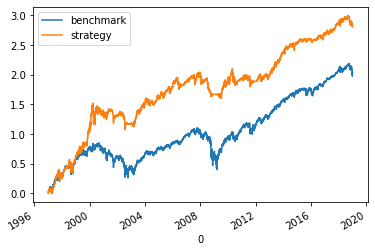

<IPython.core.display.Javascript object>

In [5]:
strat = "equity_momentum"
bench = "SPXTR"
benchmark = pd.read_csv(
    "{}{}.csv".format(data_path, bench), index_col=0, header=None, parse_dates=True
)
strategy = pd.read_csv(
    "{}{}.csv".format(data_path, strat), index_col=0, header=None, parse_dates=True
)

first_date = pd.Series([benchmark.index[0], strategy.index[0]]).max()
benchmark = benchmark[first_date:]
strategy = strategy[first_date:]

benchmark = benchmark.reindex(strategy.index).ffill()

benchmark_perc_returns = benchmark.diff() / benchmark.shift(1)
strategy_perc_returns = strategy.diff() / strategy.shift(1)

benchmark_cum_returns = benchmark_perc_returns.cumsum()
strategy_cum_returns = strategy_perc_returns.cumsum()
both_cum_returns = pd.concat([benchmark_cum_returns, strategy_cum_returns], axis=1)
both_cum_returns.columns = ["benchmark", "strategy"]
both_cum_returns.plot()

The difference in cumulative returns between strategy and benchmark:

/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


<AxesSubplot:xlabel='0'>

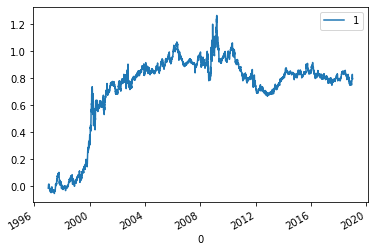

<IPython.core.display.Javascript object>

In [6]:
diff_cum_returns = strategy_cum_returns - benchmark_cum_returns
diff_cum_returns.plot()

The annual return and volatility of the strategy and the benchmark:

In [7]:
strategy_perc_returns.mean() * 256

1    0.131047
dtype: float64

<IPython.core.display.Javascript object>

In [8]:
benchmark_perc_returns.mean() * 256

1    0.094309
dtype: float64

<IPython.core.display.Javascript object>

In [9]:
strategy_perc_returns.std() * 16

1    0.202094
dtype: float64

<IPython.core.display.Javascript object>

In [10]:
benchmark_perc_returns.std() * 16

1    0.192621
dtype: float64

<IPython.core.display.Javascript object>

In terms of sharpe ratio:

In [11]:
def simple_sharpe_ratio(perc_returns):
    return (perc_returns.mean() * 256) / (perc_returns.std() * 16)

<IPython.core.display.Javascript object>

In [12]:
simple_sharpe_ratio(strategy_perc_returns)

1    0.648444
dtype: float64

<IPython.core.display.Javascript object>

In [13]:
simple_sharpe_ratio(benchmark_perc_returns)

1    0.489609
dtype: float64

<IPython.core.display.Javascript object>

Another way to compute the risk adjusted returns:

In [14]:
adjusted_benchmark_perc_returns = (
    benchmark_perc_returns * strategy_perc_returns.std() / benchmark_perc_returns.std()
)

adjusted_benchmark_cum_returns = adjusted_benchmark_perc_returns.cumsum()

diff_cum_returns = strategy_cum_returns - adjusted_benchmark_cum_returns
diff_returns = diff_cum_returns.diff()
diff_returns.mean() * 256

1    0.032879
dtype: float64

<IPython.core.display.Javascript object>

T-test to test for significance:

In [15]:
from scipy.stats import ttest_rel

ttest_rel(strategy_perc_returns, adjusted_benchmark_perc_returns, nan_policy="omit")

Ttest_relResult(statistic=masked_array(data=[0.9370850692506711],
             mask=[False],
       fill_value=1e+20), pvalue=masked_array(data=0.34875569,
             mask=False,
       fill_value=1e+20))

<IPython.core.display.Javascript object>

A non-parametric way to do the t-test:

<AxesSubplot:ylabel='Frequency'>

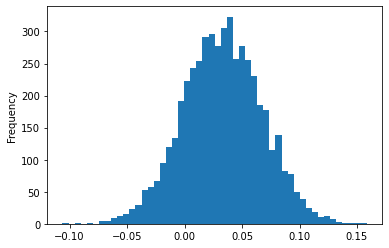

<IPython.core.display.Javascript object>

In [16]:
monte_carlo_runs = 5000  # make this larger if your computer can cope
length_returns = len(diff_returns.index)
bootstraps = [
    [
        int(np.random.uniform(high=length_returns))
        for _not_used1 in range(length_returns)
    ]
    for _not_used2 in range(monte_carlo_runs)
]


def average_given_bootstrap(one_bootstrap, diff_returns):
    subset_returns = diff_returns.iloc[one_bootstrap]
    average_for_bootstrap = np.float(subset_returns.mean() * 256)
    return average_for_bootstrap


bootstrapped_return_differences = [
    average_given_bootstrap(one_bootstrap, diff_returns) for one_bootstrap in bootstraps
]

bootstrapped_return_differences = pd.Series(bootstrapped_return_differences)

bootstrapped_return_differences.plot.hist(bins=50)

In [17]:
sum(bootstrapped_return_differences < 0) / float(len(bootstrapped_return_differences))

0.1642

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='benchmark', ylabel='strategy'>

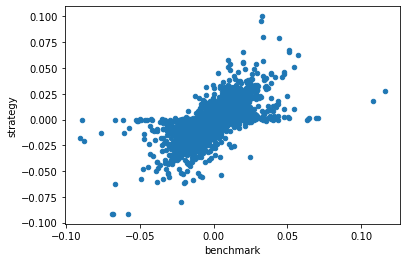

<IPython.core.display.Javascript object>

In [18]:
both_returns = pd.concat([strategy_perc_returns, benchmark_perc_returns], axis=1)
both_returns.columns = ['strategy', 'benchmark']


both_returns.plot.scatter(x="benchmark", y="strategy")


In [19]:
lm = smf.ols(formula="strategy ~ benchmark", data=both_returns).fit()
lm.params

Intercept    0.000245
benchmark    0.723262
dtype: float64

<IPython.core.display.Javascript object>

Intercept is $\alpha$ and benchmark is $\beta$ (in daily terms, to annualize, multiply by 256).

In [20]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strategy   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     5011.
Date:                Sun, 15 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:15:51   Log-Likelihood:                 18131.
No. Observations:                5536   AIC:                        -3.626e+04
Df Residuals:                    5534   BIC:                        -3.625e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.000      1.995      0.046    4.24e-06       0.000
benchmark      0.7233      0.010     70.790      0.000       0.703       0.743
==============================================================================
Omnibus:                      868.248   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14221.552
Skew:                          -0.172   Prob(JB):                         0.00
Kurtosis:                      10.845   Cond. No.                         83.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

Is the flat relative performance of the strategy after 2005 significant?

In [21]:
split_date = pd.datetime(2006, 1, 1)
ttest_ind(
    diff_returns[diff_returns.index < split_date],
    diff_returns[diff_returns.index >= split_date],
    nan_policy="omit",
)

Ttest_indResult(statistic=masked_array(data=[1.7622089240138004],
             mask=[False],
       fill_value=1e+20), pvalue=masked_array(data=0.07808921,
             mask=False,
       fill_value=1e+20))

<IPython.core.display.Javascript object>

If we allocate 100% of our capital to the strategy until January 2006 (since the strategy is much better), and thereafter put 50% in each of the strategy and the benchmark (since they seem to do equally well after that):

In [22]:
strategy_weight = pd.Series(
    [0.0] * len(strategy_perc_returns), index=strategy_perc_returns.index
)
benchmark_weight = pd.Series(
    [0.0] * len(benchmark_perc_returns), index=benchmark_perc_returns.index
)

strategy_weight[strategy_weight.index < split_date] = 1.0
benchmark_weight[benchmark_weight.index < split_date] = 0.0

strategy_weight[strategy_weight.index >= split_date] = 0.5
benchmark_weight[benchmark_weight.index >= split_date] = 0.5

both_weights = pd.concat([strategy_weight, benchmark_weight], axis=1)
both_returns = pd.concat([strategy_perc_returns, benchmark_perc_returns], axis=1)
both_weights.columns = both_returns.columns = ["strategy", "benchmark"]

implicit_fit_returns = both_weights * both_returns
implicit_fit_returns = implicit_fit_returns.sum(axis=1)

<IPython.core.display.Javascript object>

If we allocate based on 5 year returns:

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=640.0,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


<AxesSubplot:xlabel='0'>

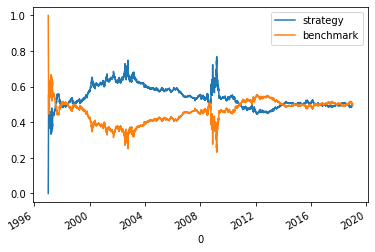

<IPython.core.display.Javascript object>

In [23]:
rolling_means = pd.ewma(both_returns, halflife=2.5 * 256)
rolling_means = rolling_means + (0.16 / 256)
rolling_means[rolling_means < 0] = 0.000001
total_mean_to_normalise = rolling_means.sum(axis=1)
total_mean_to_normalise = pd.concat([total_mean_to_normalise] * 2, axis=1)
total_mean_to_normalise.columns = rolling_means.columns
rolling_weights = rolling_means / total_mean_to_normalise
rolling_weights.plot()

Compare the two allocation approaches:

/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


<AxesSubplot:xlabel='0'>

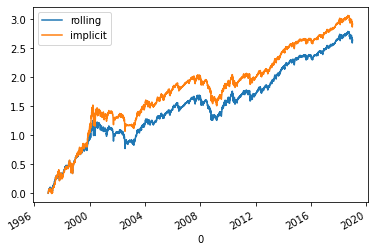

<IPython.core.display.Javascript object>

In [24]:
rolling_fit_returns = rolling_weights*both_returns
rolling_fit_returns = rolling_fit_returns.sum(axis=1)

compare_returns = pd.concat([rolling_fit_returns, implicit_fit_returns], axis=1)
compare_returns.columns = ['rolling', 'implicit']
compare_returns.cumsum().plot()


/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


<AxesSubplot:xlabel='0'>

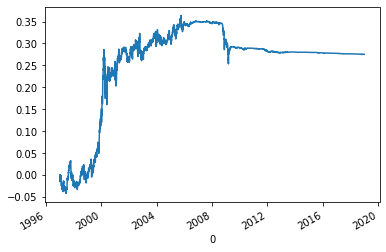

<IPython.core.display.Javascript object>

In [25]:
diff_compare = implicit_fit_returns - rolling_fit_returns
diff_compare.cumsum().plot()

In [26]:
simple_sharpe_ratio(rolling_fit_returns)

0.6726150030121897

<IPython.core.display.Javascript object>

In [27]:
simple_sharpe_ratio(implicit_fit_returns)

0.6755530191935004

<IPython.core.display.Javascript object>

Unsurprisingly the implicit fit does better than the rolling fit, with all the outperformance happening before 2008 when it cheats by allocating everything to the strategy. After 2009 both methods are doing pretty much the same thing (in 2008 the implicit fit does slightly better, as it still has a higher weight in the strategy which outperforms the benchmark).

Just by doing a little cheating we’ve managed to nudge up the Sharpe Ratio. Imagine how much extra we’d get if did some serious fiddling? Before long, you could have a Sharpe Ratio of 2.0, and believe you are a genius trader who can safely use excessive leverage, and afford to pay handsome trading costs to your broker. These are dangerous assumptions which will have a depressing end result: an empty trading account.

 
Be very careful that you don’t head down the path of implicit fitting. Only use data that would really have been available in the past to modify, fit, or allocate to trading strategies.